# N-Test implementation

General algorithm for N-tests on stocahstic event sets; taken from the shared document.

As regards the N-test, it could be replaced by this test. (The null hypothesis remains the same).
* We sum the total number of earthquakes occurred, $M_{obs}$.
* We count the same quantity in each simulated catalog to get $M_{obs(s)}$ where the index s indicates the s-th simulated catalog. The set of $M_{obs(s)}$ allows us to build numerically the distribution of M, given the model is 'true'. 
* The test compares $M_{obs(s)}$ with the empirical distribution, i.e., the P-value of the test is the percentile of the empirical distribution smaller/larger than $M_{obs(s)}$.


In [1]:
import time
import os
import csep
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load Comcat Catalog and Stocahstic Event Set

In [2]:
# need comcat catalog
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude > 3.95')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {:.2f} and Max Latitude: {:.2f}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {:.2f} and Max Longitude: {:.2f}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {:.2f} and Max Magnitude: {:.2f}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 7.6857428550720215 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.24 and Max Latitude: 41.52
Min Longitude: -124.41 and Max Longitude: -113.19
Min Magnitude: 3.96 and Max Magnitude: 6.30



In [3]:
# load in ucerf3 etas calculation
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')

t0 = time.time()
u3catalogs = csep.load_stochastic_event_set(filename=filename, type='ucerf3', format='native', name='UCERF3-ETAS')
# Example of functional programming to apply function to stochastic event set
u3catalogs_filt = list(map(lambda x: x.filter('magnitude > 3.95'), u3catalogs))
t1 = time.time()
print('Loaded {} UCERF3 catalogs in {} seconds.\n'.format(len(u3catalogs_filt), (t1-t0)))

Loaded 10000 UCERF3 catalogs in 13.799238204956055 seconds.



## Get cumulative distributions

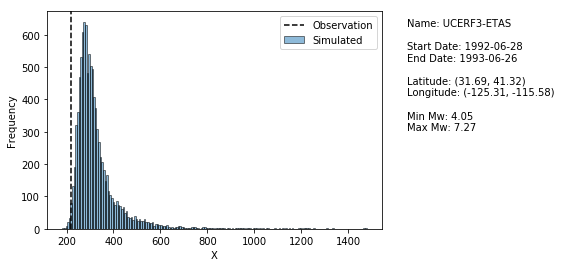

In [4]:
from csep.utils.plotting import plot_histogram
sim_counts = [catalog.get_number_of_events() for catalog in u3catalogs_filt]
comcat_count = comcat.get_number_of_events()

plot_histogram(sim_counts, comcat_count, catalog=u3catalogs_filt[0], plot_args={'x_label': 'Event Counts'})

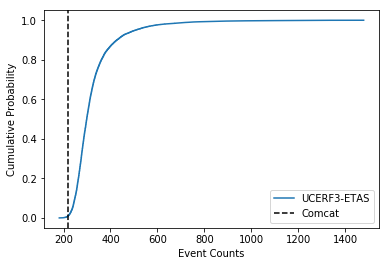

In [5]:
from csep.utils.stats import ecdf

x, cdf = ecdf(sim_counts)
fig, ax = subplots()
ax.plot(x, cdf, label='UCERF3-ETAS')
xlabel('Event Counts')
ylabel('Cumulative Probability')
axvline(x=comcat_count, color='black', linestyle='--', label='Comcat')
legend(loc='best')

In [6]:
from scipy.interpolate import interp1d
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def func_inverse(x, y, val):
    f = interp1d(x,y)
    return f(val)

p_value = func_inverse(x, cdf, comcat_count)
print('P(X ≤ x) = {}'.format(p_value))

P(X ≤ x) = 0.011


## Putting it Together -- The N-Test

We can place evaluations into two main categories. Those which a single statistic is estimated from a catalog versus those were a distribution are estimated. The N-Test represents an example of the former. This distinction might help us understanding the power of different types of evaluations.

In [7]:
def number_test(stochastic_event_set, observation):
    """
    Perform an N-Test on a stochastic event set and observation.
    
    Note: 
        Catalogs must implement get_number_of_events() method for this function to work.
    """
    # get number of events for observations and simulations
    sim_counts = [catalog.get_number_of_events() for catalog in u3catalogs_filt]
    comcat_count = comcat.get_number_of_events()
    
    # get function and interpolator based on empirical cdf
    x, cdf = ecdf(sim_counts)
    
    # p-value represents P(X <= x)
    p_value = func_inverse(x, cdf, comcat_count)
    
    return p_value

In [8]:
p_value = number_test(u3catalogs_filt, comcat)
print('P(X ≤ x) = {}'.format(p_value))

P(X ≤ x) = 0.011


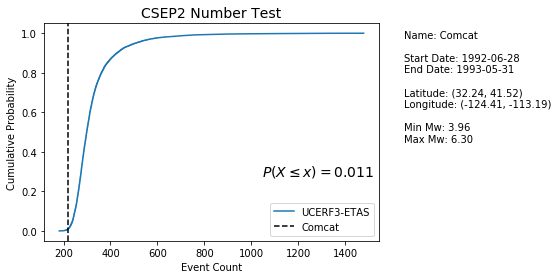

In [9]:
from csep.core.evaluations import number_test as csep_number_test

p_value, ax = csep_number_test(u3catalogs_filt, comcat, plot=True, plot_args={'show': True})